# WeRateDogs Data Wrangling

The dataset that we will wrangle consists of three sources:

**The tweet archive of Twitter user @dog_rates.**

The site is also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

**Additional Data via the Twitter API**

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. We're going to query Twitter's API to gather this valuable data.

**The Image Predictions File**
Thirdly, we have got access to results of a neural network that can classify breeds of dogs!

So, we will clean this data and at the prepare a dataset for visualization and statistical analysis.


## Gather
First of all we will import all required libraries.

In [1]:
#connect to the internet
import requests

#deal with data
import numpy as np
import pandas as pd

#deal with datetime
import datetime as dt
import pytz

#deal with visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#use padasql for SQL-query on dataframe
#http://blog.yhat.com/posts/pandasql-intro.html
from pandasql import sqldf

### gather twitter-archive-enhanced.csv file
Read the locally stored file regarding the twitter archive

In [2]:
df_twarchive = pd.read_csv('twitter-archive-enhanced.csv')

### gather image-predictions.tsv file

In [3]:
tgt_filename = 'image-predictions.tsv'

Download the image predictions file from the cloud

In [15]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(tgt_filename, 'wb') as file:
    file.write(r.content)

In [6]:
#read dataframe from file
df_image = pd.read_csv(tgt_filename, sep = '\t')
df_image.tweet_id.count()

2075

### gather tweed_json.txt

We gather each tweet's retweet count and favorite ("like") count using the **tweet IDs in the WeRateDogs Twitter archive.**

We woill query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file.
- tweet ID
- retweet count
- favorite count

In [7]:
#refer to twitter application https://apps.twitter.com/app/14714948/keys
#import authorization variables for security reasons
import access.my_secret as xs
import tweepy

auth = tweepy.OAuthHandler(xs.consumer_key, xs.consumer_secret)
auth.set_access_token(xs.access_token, xs.access_secret)
api = tweepy.API(auth)


In [8]:
#Extract tweet in json format from twitter api:
def get_tweet(tweet_id):
    tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit=True)
    return tweet._json

In [9]:
# for testing
# print(get_tweet(666082916733198337))

In [10]:
#get the timer set up
from timeit import default_timer as timer
import datetime
import json

json_filename = 'tweet_json.txt'

In [22]:
#get tweet
#write json file line by line and log progress
with open(json_filename, 'w') as file, open('log.txt','w') as log:
    for tweet_id in df_twarchive.tweet_id:
        result = ''
        start = timer()
        try:
            content = get_tweet(tweet_id)
            #add newline is helpful to read the file line by line later
            file.write(json.dumps(content) + '\n')
            result = 'ok'
        except tweepy.TweepError:
            result = 'TweepError'
        end = timer()
        log.write(('%s\t%s\t%s\t%s\n') % (str(datetime.datetime.now()), result, str(tweet_id), str(end - start)))
        

In [11]:
#count number of tweets
i = 0
with open(json_filename, 'r') as file:  
    for row in file:
        i += 1
print("row count:", i)

row count: 2345


## Assess

After gathering each of the above pieces of data, we assess them visually and programmatically for quality and tidiness issues. We detect and document at least **eight (8) quality issues and two (2) tidiness issues** in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the **issues that satisfy the Project Motivation must be assessed.**

### assess twitter-archive-enhanced.csv file
Most of the quality issue have been detected in the twitter archvie file. Theese are typical isses. We will deal with them one at a time.

#### quality issues
1. derive clear categories for source(iPhone App, vine.co, Twitter Web Client, TweetDeck)
2. make this source column categorical
3. deal with a few invalid ratings where rating_numerator is 0 or rating_denominator is 0
    - 835246439529840640 rating has been changed to from 960/0 to 13/10 according to current twitter post
    - 835152434251116546 rating has been changed to from 0/10 to 11/10 according to current twitter post
    - 746906459439529985 no rating according to current twitter post -> filter out
4. take out ratings with a rating_denominator other than 10 as these are invalid ratings or rate multiple dogs at once.
5. take out ratings with rating_numerator > 15 they seem to be invalid
6. take out retweeds You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets. (retweeted_status_id is NaN)
7. convert wrong dog names to Null: "a", "the", "an", "n", "None"

#### tidyness issues
1. four columns for the dog_stage can be put into one categorial variable (doggo,floofer,pupper,puppo) and turn the default value "None" into a Null or "unknown"

First of all we look at the data structure and sample data.

In [17]:
df_twarchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
df_twarchive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2268,667517642048163840,NaN,NaN,2015-11-20 01:39:42 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Dook &amp; Milo. Dook is struggling to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667517642...,8,10,Dook,None,None,None,None
1652,683481228088049664,NaN,NaN,2016-01-03 02:53:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Banjo. He's a Peppercorn Shoop Da Whoop. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683481228...,11,10,Banjo,None,None,pupper,None
867,761976711479193600,NaN,NaN,2016-08-06 17:26:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shelby. She finds stuff to put on her ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761976711...,12,10,Shelby,None,None,None,None
1743,679405845277462528,NaN,NaN,2015-12-22 20:59:10 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Crazy unseen footage from Jurassic Park. 10/10...,NaN,NaN,NaN,https://vine.co/v/iKVFEigMLxP,10,10,None,None,None,None,None
1483,693262851218264065,NaN,NaN,2016-01-30 02:41:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I hope you guys enjoy this beautiful snowy pup...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693262851...,11,10,None,None,None,pupper,None


Analysing the twitter sources reveals that the site owner creates most of the tweets from his iPhone. 

Only a few other sources are relvant. We will clean this up

In [20]:
df_twarchive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

The tweets range from End of 2015 to August 2017.

In [16]:
#check the latest tweet
print(df_twarchive.timestamp.min())
print(df_twarchive.timestamp.max())


2015-11-15 22:32:08 +0000
2017-08-01 16:23:56 +0000


In [21]:
df_twarchive.describe()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### Analyse 0 values in the rating system
I've analysed zero ratings in the rating system as they are actually not allowed!

Once I've got the the twitte_id, I am able to check the current post on twitter.com

In [23]:
 df_twarchive.query('rating_numerator == 0 | rating_denominator == 0')
#835246439529840640 rating has been changed to from 960/0 to 13/10 according to current twitter post
#835152434251116546 rating has been changed to from 0/10 to 11/10 according to current twitter post
#746906459439529985 no rating according to current twitter post -> filter out


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


Furthermore the rating denomiator should be 10 according to wikipedia: https://en.wikipedia.org/wiki/WeRateDogs
        
We can also learn that the site owner is student at Campbell University in Buies Creek, **North Carolina**.
    

In [25]:
df_twarchive[['tweet_id','rating_numerator','rating_denominator']].query('rating_denominator != 10')

,tweet_id,rating_numerator,rating_denominator
313,835246439529840640,960,0
342,832088576586297345,11,15
433,820690176645140481,84,70
516,810984652412424192,24,7
784,775096608509886464,9,11
902,758467244762497024,165,150
1068,740373189193256964,9,11
1120,731156023742988288,204,170
1165,722974582966214656,4,20
1202,716439118184652801,50,50


In [ ]:
df = df_twarchive[['tweet_id','rating_numerator','rating_denominator']].query('rating_denominator == 10')
df.rating_numerator.value_counts().value_counts()
#df.query('rating_numerator > 15')


The dogs on twitter have been categories by different stages. 

Just to make sure we are all talking about the same there is a very good overview viedo on youtube:

https://www.youtube.com/watch?v=ah6fmNEtXFI

In the current data set we are talking about
- doggo
- floofer
- pupper
- pupppo


In [34]:
#check if categories are clean
categories = ['doggo', 'floofer', 'pupper', 'puppo']
for category in categories:
    print(df_twarchive[category].value_counts())
    print()

None     2259
doggo      97
Name: doggo, dtype: int64

None       2346
floofer      10
Name: floofer, dtype: int64

None      2099
pupper     257
Name: pupper, dtype: int64

None     2326
puppo      30
Name: puppo, dtype: int64



We may want to analyse dog names an further. So we want to make sure they are proberperly cleaned up.

In [35]:
df_twarchive.name.value_counts().head(20)
#convert to Null: a, the, an

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
Cooper      11
Lola        10
Tucker      10
Penny       10
Winston      9
Bo           9
Sadie        8
the          8
Buddy        7
Daisy        7
Bailey       7
Toby         7
an           7
Dave         6
Jack         6
Name: name, dtype: int64

## Assess image.csv¶

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.

Example for the data set:
    - tweet_id is the last part of the tweet URL after "status/" a simple query for tweet id would be:
    (https://twitter.com/dog_rates/status/889531135344209921)
    
    - p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
    - p1_conf is how confident the algorithm is in its #1 prediction → 95%
    - p1_dog is whether or not the #1 prediction is a breed of dog → TRUE
    - p2 is the algorithm's second most likely prediction → Labrador retriever
    - p2_conf is how confident the algorithm is in its #2 prediction → 1%
    - p2_dog is whether or not the #2 prediction is a breed of dog → TRUE
    - etc.

#### quality issues
- we have 66 duplicates and have to make sure they don't exists in the final data set

#### tidiyness  issues
2. get the best true dog prediction in one column
3. make the dog prediction categorial

In [49]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [50]:
df_image.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
455,674767892831932416,https://pbs.twimg.com/media/CV1B0WkWwAEBKVx.jpg,1,shower_curtain,0.238855,False,sarong,0.092414,False,kimono,0.056412,False
973,706681918348251136,https://pbs.twimg.com/media/Cc6jcYRXIAAFuox.jpg,1,toy_poodle,0.717584,True,miniature_poodle,0.151433,True,Norwich_terrier,0.047087,True
1183,738537504001953792,https://pbs.twimg.com/media/Cj_P7rSUgAAYQbz.jpg,1,chow,0.808737,True,gibbon,0.028942,False,Pembroke,0.026498,True
760,688828561667567616,https://pbs.twimg.com/media/CY816snW8AYltrQ.jpg,1,Cardigan,0.614231,True,skunk,0.139392,False,toilet_tissue,0.031158,False
491,675534494439489536,https://pbs.twimg.com/media/CV_7CV6XIAEV05u.jpg,1,chow,0.749368,True,schipperke,0.133738,True,Newfoundland,0.049914,True


In [51]:
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [52]:
df_image[df_image.duplicated(subset=['jpg_url'], keep='first')].head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False


### assess tweet_json.txt
To assess the JSON object I refer to 
- https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object or 
- http://support.gnip.com/sources/twitter/data_format.html with more detail on 
- http://support.gnip.com/doing-more-with-140.html


 tweet ID, retweet count, and favorite count

In [53]:
#read json file line by line
df_list=[]
with open(json_filename, 'r') as file:  
    for row in file:
        data = json.loads(row)
        df_list.append({"tweet_id":data["id"],
                        "retweet_count":data["retweet_count"],
                        "favorite_count":data["favorite_count"]
                        })
#df_tweet = pd.DataFrame.from_dict(df_list)
df_tweet = pd.DataFrame(df_list, columns=["tweet_id", "retweet_count", "favorite_count"])

In [54]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null int64
retweet_count     2345 non-null int64
favorite_count    2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [55]:
df_tweet.describe()

,tweet_id,retweet_count,favorite_count
count,2.345000e+03,2345.000000,2345.000000
mean,7.423760e+17,3078.081876,8114.238380
std,6.836820e+16,5105.627191,12189.503552
min,6.660209e+17,0.000000,0.000000
25%,6.783802e+17,614.000000,1410.000000
50%,7.189719e+17,1437.000000,3574.000000
75%,7.987057e+17,3585.000000,10068.000000
max,8.924206e+17,78450.000000,142572.000000


In [56]:
df_tweet[df_tweet.retweet_count>70000]

,tweet_id,retweet_count,favorite_count
1029,744234799360020481,78450,129628


In [57]:
df_twarchive[df_twarchive.tweet_id == 744234799360020481]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1039,744234799360020481,NaN,NaN,2016-06-18 18:26:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744234799...,13,10,None,doggo,None,None,None


## Assess new file twitter_archive_master.csv
In order to anaylse the data from all different sources we will have to merge them into one data set.
#### tidyness issues
- merge all three dataset into one
- drop columns in the merged data set which are not required

## Clean

Next we will clean each of the issues you documented while assessing. We will perform this cleaning in wrangle_act.ipynb as well. The result should be a high quality and tidy master pandas DataFrame.

#### Clean df_twarchive = pd.read_csv('twitter-archive-enhanced.csv')


In [58]:
#preserve the raw data
dfc_twarchive = df_twarchive.copy()

#### Define
- generate mapping dictionary to map to a short description with clear clear categories iPhone App, vine.co, Twitter Web Client, TweetDeck
- create function to change source
- call function
- change datatype to categorial

#### Code

In [59]:
dfc_twarchive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [60]:
ref_source = {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone App',
              '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'vine.co', 
              '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
              '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'}

def clean_source(tweet):
    if tweet['source'] in ref_source.keys():
        #return clean description
        return ref_source[tweet['source']]
    else:
        return dfc_twarchive.source

dfc_twarchive.source = dfc_twarchive.apply(clean_source, axis=1)

dfc_twarchive.source = dfc_twarchive.source.astype('category')

#### Test

In [61]:
dfc_twarchive.source.value_counts()


iPhone App            2221
vine.co                 91
Twitter Web Client      33
TweetDeck               11
Name: source, dtype: int64

In [62]:
dfc_twarchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null category
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: category(1), float64(4

#### Define
- deal with a few invalid ratings where rating_numerator is 0 or rating_denominator is 0
    - 835246439529840640 rating has been changed to from 960/0 to 13/10 according to current twitter post
    - 835152434251116546 rating has been changed to from 0/10 to 11/10 according to current twitter post
    - 746906459439529985 no rating according to current twitter post -> filter out


#### Code

In [63]:
#update df cell
#see https://stackoverflow.com/questions/12307099/modifying-a-subset-of-rows-in-a-pandas-dataframe/44913631#44913631
dfc_twarchive.loc[dfc_twarchive.tweet_id == 835246439529840640, 'rating_numerator'] = 13
dfc_twarchive.loc[dfc_twarchive.tweet_id == 835246439529840640, 'rating_denominator'] = 10

dfc_twarchive.loc[dfc_twarchive.tweet_id == 835152434251116546, 'rating_numerator'] = 11

dfc_twarchive = dfc_twarchive[dfc_twarchive.tweet_id != 746906459439529985]

#### Test

In [64]:
dfc_twarchive.loc[dfc_twarchive.tweet_id.isin([835246439529840640, 835152434251116546, 746906459439529985])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,iPhone App,@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,iPhone App,When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,11,10,None,None,None,None,None


#### Define
- take out ratings with a rating_denominator other than 10 as these are invalid ratings or rate multiple dogs at once.
- take out ratings with rating_numerator > 15 they seem to be invalid
- take out retweets You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets. So **keep** all tweets with retweeted_status_id is NaN


#### Code

In [65]:
#delete retweets
dfc_twarchive = dfc_twarchive[dfc_twarchive.retweeted_status_id.isnull()]

In [66]:
dfc_twarchive = dfc_twarchive[dfc_twarchive.rating_denominator == 10]
dfc_twarchive = dfc_twarchive[dfc_twarchive.rating_numerator <= 15]

#### Test

In [67]:
dfc_twarchive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.144000e+03,6.900000e+01,6.900000e+01,0.0,0.0,2144.000000,2144.0
mean,7.370728e+17,7.403786e+17,2.276889e+16,NaN,NaN,10.630131,10.0
std,6.754280e+16,7.383460e+16,1.330848e+17,NaN,NaN,2.171990,0.0
min,6.660209e+17,6.658147e+17,1.185634e+07,NaN,NaN,1.000000,10.0
25%,6.766166e+17,6.753494e+17,1.198989e+09,NaN,NaN,10.000000,10.0
50%,7.095381e+17,7.030419e+17,4.196984e+09,NaN,NaN,11.000000,10.0
75%,7.895480e+17,8.131273e+17,4.196984e+09,NaN,NaN,12.000000,10.0
max,8.924206e+17,8.862664e+17,8.405479e+17,NaN,NaN,15.000000,10.0


#### Define
- convert wrong dog names to Null: "a", "the", "an", "n"

#### Code

In [68]:
# Deal with value=None
# see https://stackoverflow.com/questions/17097236/how-to-replace-values-with-none-in-pandas-data-frame-in-python
dfc_twarchive.name = dfc_twarchive.name.replace(to_replace=['^(a|an|the|n|None)$'], value=[None], regex=True)

#### Test

In [69]:
dfc_twarchive.loc[dfc_twarchive.name.isin(['a', 'an', 'the', 'n', 'None'])].name.count()


0

#### Define

#### tidyness issues
- four columns for the dog_stage can be put into one categorial variable (doggo,floofer,pupper,puppo) and turn the default value "None" into a Null or "unknown"

#### Code

In [70]:
dfc_twarchive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2144 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2144 non-null int64
in_reply_to_status_id         69 non-null float64
in_reply_to_user_id           69 non-null float64
timestamp                     2144 non-null object
source                        2144 non-null category
text                          2144 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2093 non-null object
rating_numerator              2144 non-null int64
rating_denominator            2144 non-null int64
name                          1419 non-null object
doggo                         2144 non-null object
floofer                       2144 non-null object
pupper                        2144 non-null object
puppo                         2144 non-null object
dtypes: category(1), float64(4), int

In [71]:
#concat the stage columns doggo,floofer,pupper,puppo while replacing the None wordw with an empty string
dfc_twarchive['dog_stage'] = dfc_twarchive.doggo.replace('None','') + dfc_twarchive.floofer.replace('None','') + dfc_twarchive.pupper.replace('None','') + dfc_twarchive.puppo.replace('None','')
dfc_twarchive['dog_stage'] = dfc_twarchive['dog_stage'].replace(to_replace=[''], value=[None], regex=False)


In [72]:
dfc_twarchive['dog_stage'].value_counts()

pupper          223
doggo            75
puppo            24
doggopupper      10
floofer           9
doggopuppo        1
doggofloofer      1
Name: dog_stage, dtype: int64

In [73]:
# get rid of dog stages which are not defined
# https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row
for row in dfc_twarchive.itertuples():
    if dfc_twarchive.loc[row.Index, 'dog_stage'] in ['doggo','floofer','pupper','puppo']:
        next
    else:
        dfc_twarchive.loc[row.Index, 'dog_stage'] = None
dfc_twarchive['dog_stage'].value_counts()

pupper     223
doggo       75
puppo       24
floofer      9
Name: dog_stage, dtype: int64

In [74]:
dfc_twarchive['dog_stage'] = dfc_twarchive['dog_stage'].astype('category')

#### Test

In [75]:
dfc_twarchive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2144 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2144 non-null int64
in_reply_to_status_id         69 non-null float64
in_reply_to_user_id           69 non-null float64
timestamp                     2144 non-null object
source                        2144 non-null category
text                          2144 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2093 non-null object
rating_numerator              2144 non-null int64
rating_denominator            2144 non-null int64
name                          1419 non-null object
doggo                         2144 non-null object
floofer                       2144 non-null object
pupper                        2144 non-null object
puppo                         2144 non-null object
dog_stage                     331 no

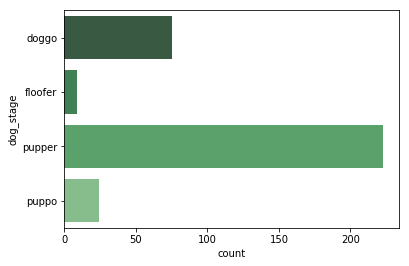

In [76]:
sns.countplot(y="dog_stage", data=dfc_twarchive, palette="Greens_d");

#### Define
drop all irrelevant columns

#### Code

In [77]:
dfc_twarchive.drop(['in_reply_to_status_id', 
                    'in_reply_to_user_id', 
                    'retweeted_status_id', 
                    'retweeted_status_user_id', 
                    'retweeted_status_timestamp',
                    'doggo',
                    'floofer',
                    'pupper',
                    'puppo'], axis=1, inplace=True)

#### Test

In [78]:
dfc_twarchive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2144 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2144 non-null int64
timestamp             2144 non-null object
source                2144 non-null category
text                  2144 non-null object
expanded_urls         2093 non-null object
rating_numerator      2144 non-null int64
rating_denominator    2144 non-null int64
name                  1419 non-null object
dog_stage             331 non-null category
dtypes: category(2), int64(3), object(4)
memory usage: 218.6+ KB


### clean image-predictions.tsv file

In [79]:
dfc_image = df_image.copy()

#### Define
- Go through each line and look for true dog predictions from column 1 to column 3.
- Stop at the first occurence of a dog prediction
- Write that info into a separate field
- make that the dog prediction column categorial

#### Code

In [80]:
dfc_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [81]:
#make sure the priority is correct in the columns
dfc_image.query('p1_conf < p2_conf | p2_conf < p3_conf | p1_conf < p3_conf')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [82]:
#merge thre dog columns into one according to priority
df_p1 = dfc_image[dfc_image.p1_dog == True].filter(items=['tweet_id','jpg_url','p1','p1_conf']) 
df_p1 = df_p1.rename(columns={'p1': 'dog', 'p1_conf': 'conf'})
df_p2 = dfc_image.query('p1_dog == False & p2_dog == True').filter(items=['tweet_id','jpg_url','p2','p2_conf']) 
df_p2 = df_p2.rename(columns={'p2': 'dog', 'p2_conf': 'conf'})
df_p3 = dfc_image.query('p1_dog == False & p2_dog == False & p3_dog == True').filter(items=['tweet_id','jpg_url','p3','p3_conf'])
df_p3 = df_p3.rename(columns={'p3': 'dog', 'p3_conf': 'conf'})
dfc_image = pd.concat([df_p1, df_p2, df_p3])


    

In [83]:
dfc_image.dog = dfc_image.dog.astype('category')

#### Test

In [84]:
dfc_image.head(5)

,tweet_id,jpg_url,dog,conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311


In [85]:
dfc_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2026
Data columns (total 4 columns):
tweet_id    1751 non-null int64
jpg_url     1751 non-null object
dog         1751 non-null category
conf        1751 non-null float64
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 62.3+ KB


In [86]:
df_image.query('tweet_id == 666044226329800704')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True


#### Define
join together dfc_twarchive x df_tweet
add image info if it exists from dfc_image

#### Code

In [87]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null int64
retweet_count     2345 non-null int64
favorite_count    2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [88]:
j1 = pd.merge(dfc_twarchive, df_tweet, on='tweet_id')
#filter out dogs where we don't know the type
df_master = pd.merge(j1, dfc_image, on='tweet_id')


In [89]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1664 entries, 0 to 1663
Data columns (total 14 columns):
tweet_id              1664 non-null int64
timestamp             1664 non-null object
source                1664 non-null category
text                  1664 non-null object
expanded_urls         1664 non-null object
rating_numerator      1664 non-null int64
rating_denominator    1664 non-null int64
name                  1203 non-null object
dog_stage             249 non-null category
retweet_count         1664 non-null int64
favorite_count        1664 non-null int64
jpg_url               1664 non-null object
dog                   1664 non-null category
conf                  1664 non-null float64
dtypes: category(3), float64(1), int64(5), object(5)
memory usage: 167.1+ KB


In [90]:
df_master.sample(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,dog,conf
1353,674014384960745472,2015-12-07 23:55:26 +0000,iPhone App,Say hello to Aiden. His eyes are magical. Love...,https://twitter.com/dog_rates/status/674014384...,11,10,Aiden,NaN,705,1653,https://pbs.twimg.com/media/CVqUgTIUAAUA8Jr.jpg,Pembroke,0.74232


In [91]:
df_master[df_master.jpg_url.isnull()].count()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating_numerator      0
rating_denominator    0
name                  0
dog_stage             0
retweet_count         0
favorite_count        0
jpg_url               0
dog                   0
conf                  0
dtype: int64

#### Test

In [92]:
#proove that there is no duplicate jpg anymore.
df_master[df_master.duplicated(subset=['jpg_url'], keep='first')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,dog,conf


#### Define
According to wikipedia (https://en.wikipedia.org/wiki/WeRateDogs) the owner of the site is student in set timezone to EST according to wikipedia that's where the twitter account owner studies at Campbell University in Buies Creek, North Carolina.
So we will have to **change the creation of tweets to local EST timezone**.

#### Code

In [179]:
#convert object to datetime64
#https://pandas.pydata.org/pandas-docs/stable/timeseries.html
#localize to UTC and convert to EST
#https://stackoverflow.com/questions/20689288/converting-pandas-columns-to-datetime64-including-missing-values
#df_master['timestamp'] = 
df_master.timestamp = pd.to_datetime(df_master.timestamp).dt.tz_localize('UTC').dt.tz_convert('EST')
#extract local hour
df_master.create_HH24 = df_master.timestamp.dt.hour

In [180]:
df_master['create_HH24'] = df_master.timestamp.dt.hour.astype('category')

#### Test

In [181]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 15 columns):
tweet_id              1664 non-null int64
timestamp             1664 non-null datetime64[ns, EST]
source                1664 non-null category
text                  1664 non-null object
expanded_urls         1664 non-null object
rating_numerator      1664 non-null int64
rating_denominator    1664 non-null int64
name                  1203 non-null object
dog_stage             249 non-null category
retweet_count         1664 non-null int64
favorite_count        1664 non-null int64
jpg_url               1664 non-null object
dog                   1664 non-null category
conf                  1664 non-null float64
create_HH24           1664 non-null category
dtypes: category(4), datetime64[ns, EST](1), float64(1), int64(5), object(4)
memory usage: 156.5+ KB


Finally we store the intermediate result into a file for further analysis.

In [182]:
df_master.to_csv('twitter_archive_master.csv',index=False, encoding='utf-8')

## Storing, Analyzing, and Visualizing Data for this Project

Once we have cleaned the three data sets from WeRateDogs data, we stored the clean DataFrame in a CSV file with the main one named **twitter_archive_master.csv**.

Next we will analyze and visualize our wrangled data.

In [183]:
df_master = pd.read_csv('twitter_archive_master.csv')

Finally we endet up with **1664 clean data sets** in the pandas dataframe df_master

In [184]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 15 columns):
tweet_id              1664 non-null int64
timestamp             1664 non-null object
source                1664 non-null object
text                  1664 non-null object
expanded_urls         1664 non-null object
rating_numerator      1664 non-null int64
rating_denominator    1664 non-null int64
name                  1203 non-null object
dog_stage             249 non-null object
retweet_count         1664 non-null int64
favorite_count        1664 non-null int64
jpg_url               1664 non-null object
dog                   1664 non-null object
conf                  1664 non-null float64
create_HH24           1664 non-null int64
dtypes: float64(1), int64(6), object(8)
memory usage: 195.1+ KB


In order to perform statistical we define the correct data types on the existing columns

In [185]:
df_master.source = df_master.source.astype('category')
df_master.dog_stage = df_master.dog_stage.astype('category')
df_master.dog = df_master.dog.astype('category')
df_master.create_HH24 = df_master.create_HH24.astype('category')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 15 columns):
tweet_id              1664 non-null int64
timestamp             1664 non-null object
source                1664 non-null category
text                  1664 non-null object
expanded_urls         1664 non-null object
rating_numerator      1664 non-null int64
rating_denominator    1664 non-null int64
name                  1203 non-null object
dog_stage             249 non-null category
retweet_count         1664 non-null int64
favorite_count        1664 non-null int64
jpg_url               1664 non-null object
dog                   1664 non-null category
conf                  1664 non-null float64
create_HH24           1664 non-null category
dtypes: category(4), float64(1), int64(5), object(5)
memory usage: 156.5+ KB


### Correlation
Looking at persons correlation we ca just fin favorite_count and retweet_count significantly positive correlated.
Interesting enough there is also a correlation between tweet_id and favorite_count.
One possibe reson for this could be the increasing popularity of this site over time.

In [186]:
df_master.corr(method='pearson')

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,conf
tweet_id,1.000000,0.550155,NaN,0.392921,0.630534,0.103490
rating_numerator,0.550155,1.000000,NaN,0.317499,0.420476,0.142090
rating_denominator,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,0.392921,0.317499,NaN,1.000000,0.917411,0.027693
favorite_count,0.630534,0.420476,NaN,0.917411,1.000000,0.059848
conf,0.103490,0.142090,NaN,0.027693,0.059848,1.000000


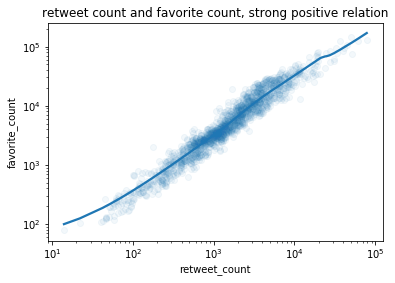

In [187]:
# Initialize figure and ax
fig, ax = plt.subplots()

# Set the scale of the x-and y-axes
ax.set(xscale="log", yscale="log")
sns.regplot(x='retweet_count', y='favorite_count', data=df_master, ax=ax, scatter_kws={'alpha':0.05},lowess=True)
plt.title('retweet count and favorite count, strong positive relation')
plt.show()

There have been even books written about the differend dog stages.

According to WeRateDogs increased retweet count are possible for doggo, floofer and puppos 
while pupper have a clear disadvanted in retwwet counts

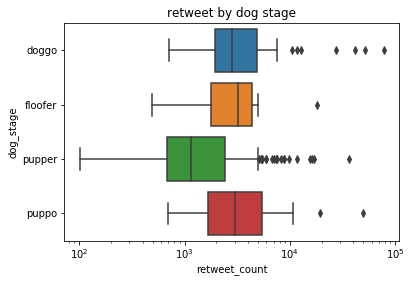

In [188]:
# Create the boxplot
ax = sns.boxplot(x="retweet_count", y="dog_stage", data=df_master)

# Set the `xlim`
ax.set(xscale="log")

# Set title
ax.set_title("retweet by dog stage")

# Show the plot
plt.show()

### students work hard, ... after 10 in the morning.
On the other hand we have to keep in mind that this site is maintained by a single student.
Most of the time by using his iPhone!
So let's proove this be looking at the creation time of the posts.

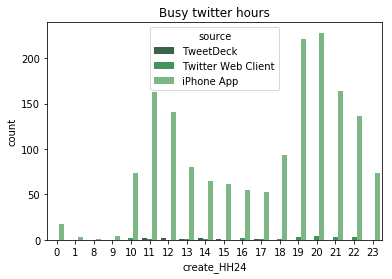

In [199]:
ax = sns.countplot(x="create_HH24", hue="source", data=df_master, palette="Greens_d")
ax.set_title('Busy twitter hours')
plt.show()

Looking at the local posting hourse in EST we could confirm that all posts have been issued during daylinght time.

Our student like to get up not earlier thant 10 am in the morning. So that story could be confirmed by this simple countplot.

After all we have to commit that there are certain dog breeds which are simply cute.

If we just look at doog breeds which have been rated more than 10 times we have to admit ...

In [202]:
#pysqldf = lambda q: sqldf(q, globals())

q = """
SELECT
 dog
,count(*) as cnt
,avg(rating_numerator) as avg_rating_numerator
,avg(retweet_count) as avg_retweet_count
,avg(favorite_count) as avg_favorite_count
FROM df_master
GROUP BY 1
having cnt>10
ORDER BY avg_favorite_count desc
;
"""

In [203]:
df_dog = pysqldf(q)
df_dog.head(10)

,dog,cnt,avg_rating_numerator,avg_retweet_count,avg_favorite_count
0,French_bulldog,31,11.193548,5179.774194,19179.161290
1,whippet,11,10.181818,4995.909091,13906.000000
2,standard_poodle,11,10.727273,5425.818182,13768.454545
3,Samoyed,42,11.690476,4763.714286,13752.071429
4,cocker_spaniel,30,11.333333,4876.466667,13708.300000
5,Great_Pyrenees,14,11.428571,4705.357143,12960.071429
6,Cardigan,21,11.142857,3737.666667,12697.285714
7,golden_retriever,154,11.551948,3679.837662,12315.740260
8,Lakeland_terrier,18,10.444444,4139.666667,12283.444444
9,Labrador_retriever,105,11.200000,3771.457143,11889.828571


In [204]:
#get details for top avg_favorite
df_master.query('dog=="French_bulldog"')[['jpg_url','favorite_count','retweet_count']].sort_values(by='favorite_count',ascending=False).head(5)

,jpg_url,favorite_count,retweet_count
100,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,122936,36460
92,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,66921,15110
58,https://pbs.twimg.com/media/DC98vABUIAA97pz.jpg,42489,7048
324,https://pbs.twimg.com/media/C0s-XtzWgAAp1W-.jpg,39958,16002
239,https://pbs.twimg.com/media/C4L7p19W8AA3Fs_.jpg,34506,12010


### You have to love a French bulldog
![You have to like a French bulldog](https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg)